In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as mx
import tensorflow as tf
import seaborn as sns
import random
import joblib
from PIL import Image
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense
from tensorflow.keras import Sequential, Model
from keras.layers import ( MaxPooling2D, Dense, Flatten, 
                          Dropout, Input,GlobalAveragePooling2D,BatchNormalization)
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix, accuracy_score)
# Base Libraries
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.models import Model
import numpy as np 
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

# Classification
from sklearn import metrics

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, cross_val_score
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet # for Lasso and Elastic Net logistic regression
# from sklearn.cross_decomposition import PLSRegression # for PLS

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report
pd.set_option('display.max_colwidth', None)

In [2]:
def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

CID = 0

In [6]:
train_path=os.listdir("dermnet/train/Psoriasis pictures Lichen Planus and related diseases/")

In [127]:
train = pd.read_csv('psoriasis_label.csv')
train['id'] = "dermnet/train/Psoriasis pictures Lichen Planus and related diseases/" + train['id'].astype('str')
train

,id,severity
0,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/erythrokeratodermia-variabilis-4.jpg,10
1,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Psoriasis-Chronic-Plaque-13.jpg,10
2,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Lichen-Planus-Oral-28.jpg,5
3,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Palmoplantar-Keratoderma-2.jpg,4
4,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/08PsoriasisOnycholysis1.jpg,2
...,...,...
462,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/reiter-syndrome-14.jpg,3
463,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Lichen-Nitidus-15.jpg,4
464,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/Pityriasis-Lichenoides-15.jpg,7
465,dermnet/train/Psoriasis pictures Lichen Planus and related diseases/pityriasis-rosea-2.jpg,5


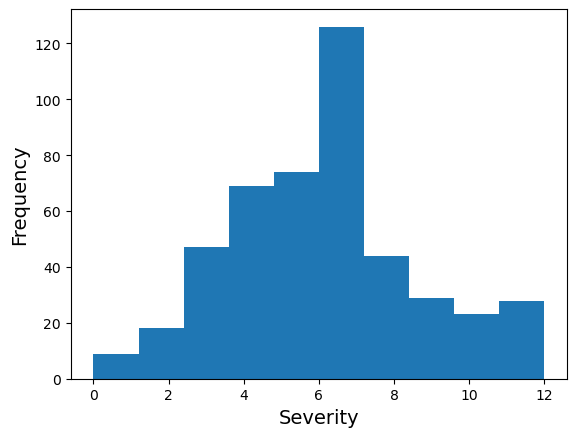

In [8]:
train['severity'].hist()
# Set x and y-axis labels
plt.xlabel('Severity', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('Frequency', fontsize=14)  # Adjust fontsize as needed

# Remove grid lines
plt.grid(False)


# Display the histogram
plt.show()

In [9]:
images=[]
label=[]
for i in train['id']:
        img=cv2.imread(i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img=cv2.resize(img,(180,180))
        images.append(img)

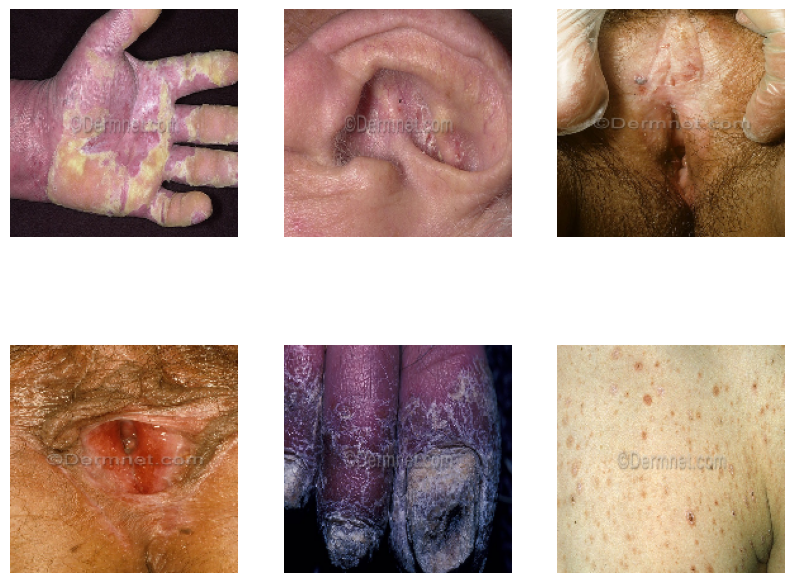

In [10]:
# Create a list of example inputs to our Gradio demo
example_list = [image for image in random.sample(images, k=6)]

# Plot the images in a 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

for ax, img_array in zip(axes.ravel(), example_list):
    ax.imshow(img_array)
    ax.axis('off')

plt.show()

In [11]:
label=train['severity']
print(len(label))
print(len(images))

467
467


In [12]:
import numpy as np
import pandas as pd

In [13]:
data=np.array(images)
label=np.array(label)
print(data.shape)
print(label.shape)

(467, 180, 180, 3)
(467,)


In [8]:
#!pip install sklearn_relief

In [14]:
vgg_model = VGG19(weights = 'imagenet',  include_top = False, input_shape = (180, 180, 3)) 
# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False

In [15]:
model=Sequential([                
                    Dense(200,activation='relu'),
                  Dense(170,activation='relu'),
                  Dense(1,activation='sigmoid'),

])

In [17]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
# not doing train test split
# LONG: 23 min 
for i in range(3): 
    # let's make all layers non-trainable
    for layer in vgg_model.layers :
        layer.trainable = False
    features=vgg_model.predict(data)
    print(features.shape)
    features=features.reshape(len(images),-1)
    print(features.shape)

15/15 [==============================] - 24s 2s/step
(467, 5, 5, 512)
(467, 12800)
15/15 [==============================] - 24s 2s/step
(467, 5, 5, 512)
(467, 12800)
15/15 [==============================] - 24s 2s/step
(467, 5, 5, 512)
(467, 12800)


In [20]:
vgg19_feature_list = np.array(features)
vgg19_feature_severity = pd.concat([train, pd.DataFrame(features)],axis = 1)
vgg19_feature_severity.to_csv('vgg19_feature_severity.csv')

# KNN Cluster of entire Dermnet

In [21]:
from sklearn.neighbors import NearestNeighbors

# Assuming your data is stored in a variable named 'data'
nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(vgg19_feature_list) # it automatically selects 'brute' for auto
distances, indices = nbrs.kneighbors(vgg19_feature_list)

In [23]:
nbrs.kneighbors_graph(vgg19_feature_list).toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [24]:
# Convert each row to a tuple, sort the tuple, and then create a set
unique_tuples = set(tuple(sorted(row)) for row in indices)

# Convert the set back to a NumPy array
unique_indices = np.array(list(unique_tuples))

print(unique_indices.shape)

# Get the indices that would sort the array along the first column
sorted_indices = np.argsort(unique_indices[:, 0])

# Use the sorted indices to reorder the array
sorted_pairs = unique_indices[sorted_indices]

(421, 2)


In [25]:
pd.DataFrame(sorted_pairs).to_csv('paired_images.csv', index=False)

In [26]:
sorted_pairs = pd.read_csv('paired_images.csv')
sorted_pairs_df = pd.DataFrame(sorted_pairs)
sorted_pairs_df = sorted_pairs_df.rename(columns={'0': "ImageA", '1': "ImageB"})
sorted_pairs_df

,ImageA,ImageB
0,0,108
1,1,108
2,1,168
3,1,16
4,1,272
...,...,...
416,432,436
417,433,436
418,435,436
419,436,464


In [27]:
train.reset_index()	

,index,id,severity
0,0,dermnet/train/Psoriasis pictures Lichen Planus...,10
1,1,dermnet/train/Psoriasis pictures Lichen Planus...,10
2,2,dermnet/train/Psoriasis pictures Lichen Planus...,5
3,3,dermnet/train/Psoriasis pictures Lichen Planus...,4
4,4,dermnet/train/Psoriasis pictures Lichen Planus...,2
...,...,...,...
462,462,dermnet/train/Psoriasis pictures Lichen Planus...,3
463,463,dermnet/train/Psoriasis pictures Lichen Planus...,4
464,464,dermnet/train/Psoriasis pictures Lichen Planus...,7
465,465,dermnet/train/Psoriasis pictures Lichen Planus...,5


In [28]:
train

,id,severity
0,dermnet/train/Psoriasis pictures Lichen Planus...,10
1,dermnet/train/Psoriasis pictures Lichen Planus...,10
2,dermnet/train/Psoriasis pictures Lichen Planus...,5
3,dermnet/train/Psoriasis pictures Lichen Planus...,4
4,dermnet/train/Psoriasis pictures Lichen Planus...,2
...,...,...
462,dermnet/train/Psoriasis pictures Lichen Planus...,3
463,dermnet/train/Psoriasis pictures Lichen Planus...,4
464,dermnet/train/Psoriasis pictures Lichen Planus...,7
465,dermnet/train/Psoriasis pictures Lichen Planus...,5


In [29]:
# Merge dataframes on the common index
merged_df = pd.merge(sorted_pairs_df, train, left_on='ImageA', right_index=True, how='left')

# Create the 'SeverityA' column
merged_df['SeverityA'] = merged_df['severity']
merged_df = merged_df.drop(['id', 'severity'], axis=1)

# Merge dataframes on the common index
merged_df = pd.merge(merged_df, train, left_on='ImageB', right_index=True, how='left')

# Create the 'SeverityA' column
merged_df['SeverityB'] = merged_df['severity']
merged_df = merged_df.drop(['id', 'severity'], axis=1)
merged_df

,ImageA,ImageB,SeverityA,SeverityB
0,0,108,10,7
1,1,108,10,7
2,1,168,10,9
3,1,16,10,12
4,1,272,10,8
...,...,...,...,...
416,432,436,10,8
417,433,436,6,8
418,435,436,11,8
419,436,464,8,7


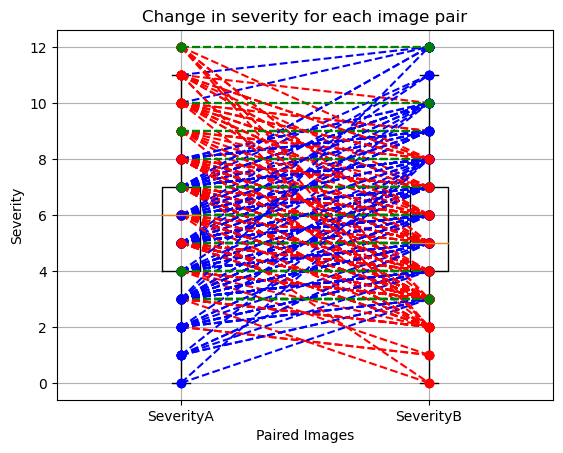

In [30]:
# Create paired box plots
bp = plt.boxplot([merged_df['SeverityA'], merged_df['SeverityB']], positions=[0, 1], labels=['SeverityA', 'SeverityB'])

# Draw lines connecting paired dots with different colors based on the relationship
for i, row in merged_df.iterrows():
    color = 'green'  # default color for equal values
    if row['SeverityB'] > row['SeverityA']:
        color = 'blue'  # blue for SeverityB > SeverityA
    elif row['SeverityB'] < row['SeverityA']:
        color = 'red'  # red for SeverityB < SeverityA
    plt.plot([0, 1], [row['SeverityA'], row['SeverityB']], color=color, linestyle='--', marker='o')

# Customize plot
plt.xlabel('Paired Images')
plt.ylabel('Severity')
plt.title('Change in severity for each image pair')
plt.grid(True)

# Show plot
plt.show()

In [31]:
merged_df['SeverityB - SeverityA'] = merged_df['SeverityB'] - merged_df['SeverityA']

In [32]:
merged_df

,ImageA,ImageB,SeverityA,SeverityB,SeverityB - SeverityA
0,0,108,10,7,-3
1,1,108,10,7,-3
2,1,168,10,9,-1
3,1,16,10,12,2
4,1,272,10,8,-2
...,...,...,...,...,...
416,432,436,10,8,-2
417,433,436,6,8,2
418,435,436,11,8,-3
419,436,464,8,7,-1


In [33]:
# Function to categorize values
def categorize_value(value):
    if value > 0:
        return 'Worsened'
    elif value < 0:
        return 'Improved'
    else:
        return 'No change'

# Apply the function to create a new categorical column
merged_df['Progression'] = merged_df['SeverityB - SeverityA'].apply(categorize_value)
merged_df

,ImageA,ImageB,SeverityA,SeverityB,SeverityB - SeverityA,Progression
0,0,108,10,7,-3,Improved
1,1,108,10,7,-3,Improved
2,1,168,10,9,-1,Improved
3,1,16,10,12,2,Worsened
4,1,272,10,8,-2,Improved
...,...,...,...,...,...,...
416,432,436,10,8,-2,Improved
417,433,436,6,8,2,Worsened
418,435,436,11,8,-3,Improved
419,436,464,8,7,-1,Improved


In [34]:
# add Image names
merged_df['ImageA_path'] = vgg19_feature_severity['id'][merged_df['ImageA']].reset_index(drop=True).str.replace('dermnet/train/Psoriasis pictures Lichen Planus and related diseases/', '')
merged_df['ImageB_path'] = vgg19_feature_severity['id'][merged_df['ImageB']].reset_index(drop=True).str.replace('dermnet/train/Psoriasis pictures Lichen Planus and related diseases/', '')

In [35]:
merged_df.to_csv('paired_image_severity.csv')

# Robust KNN (KNN done separately on training and testing images)

Originally there are 467 images, but after train-test split only 428 left

In [132]:
pairs_by_name_train = pd.read_csv('pairs_by_name_train.csv')
pairs_by_name_test = pd.read_csv('pairs_by_name_test.csv')

In [133]:
# Combine values from both columns and convert to a set to get unique items
image_train = list(set(pairs_by_name_train['ImageA'].tolist() + pairs_by_name_train['ImageB'].tolist()))
print(len(image_train))

image_test = list(set(pairs_by_name_test['ImageA'].tolist() + pairs_by_name_test['ImageB'].tolist()))
print(len(image_test))

# Check if there are overlapping values
overlap = bool(set(image_train) & set(image_test))
if overlap:
    print("The lists have overlapping values.")
else:
    print("The lists do not have overlapping values.")

print('Total number of images in two lists are', len(image_train) + len(image_test))

293
135
The lists do not have overlapping values.
Total number of images in two lists are 428


In [134]:
vgg19_feature_severity = pd.read_csv('vgg19_feature_severity.csv',index_col=0)
vgg19_feature_severity['id'] = vgg19_feature_severity['id'].str.replace("dermnet/train/Psoriasis pictures Lichen Planus and related diseases/", '')
vgg19_feature_severity

,id,severity,0,1,2,3,4,5,6,7,...,12790,12791,12792,12793,12794,12795,12796,12797,12798,12799
0,erythrokeratodermia-variabilis-4.jpg,10,4.267727,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,4.790735,54.445866,0.000000,0.0,0.000000,0.000000,21.140205,0.0
1,Psoriasis-Chronic-Plaque-13.jpg,10,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,8.161653,7.837052,10.883604,0.0,0.000000,0.000000,0.000000,0.0
2,Lichen-Planus-Oral-28.jpg,5,0.000000,0.0,0.0,16.705368,12.607100,0.000000,2.40042,5.679642,...,25.521635,0.0,0.000000,10.020402,0.000000,0.0,36.357765,0.000000,2.955516,0.0
3,Palmoplantar-Keratoderma-2.jpg,4,0.000000,0.0,0.0,1.627664,0.349453,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,12.166387,0.000000,0.0
4,08PsoriasisOnycholysis1.jpg,2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,reiter-syndrome-14.jpg,3,0.193476,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
463,Lichen-Nitidus-15.jpg,4,7.712959,0.0,0.0,1.568991,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.788425,0.0
464,Pityriasis-Lichenoides-15.jpg,7,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,4.699575,0.0
465,pityriasis-rosea-2.jpg,5,0.000000,0.0,0.0,0.000000,0.000000,16.200745,0.00000,0.000000,...,0.000000,0.0,1.399691,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [135]:
# create vgg19_severity train and test df
vgg19_feature_severity_train = vgg19_feature_severity[vgg19_feature_severity['id'].isin(image_train)]
vgg19_feature_severity_train['index'] = range(0, 0 + len(vgg19_feature_severity_train)) 
vgg19_feature_severity_train = vgg19_feature_severity_train[['index'] + [col for col in vgg19_feature_severity_train.columns if col != 'index']]

vgg19_feature_severity_test = vgg19_feature_severity[vgg19_feature_severity['id'].isin(image_test)]
vgg19_feature_severity_test['index'] = range(0, 0 + len(vgg19_feature_severity_test)) 
vgg19_feature_severity_test = vgg19_feature_severity_test[['index'] + [col for col in vgg19_feature_severity_test.columns if col != 'index']]

/var/folders/vt/y72wtch959d241m26rz762980000gq/T/ipykernel_52555/2034510763.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vgg19_feature_severity_train['index'] = range(0, 0 + len(vgg19_feature_severity_train))
/var/folders/vt/y72wtch959d241m26rz762980000gq/T/ipykernel_52555/2034510763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vgg19_feature_severity_test['index'] = range(0, 0 + len(vgg19_feature_severity_test))


In [136]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(vgg19_feature_severity_train.iloc[:, 3:]) # it automatically selects 'brute' for auto
distances_train, indices_train = nbrs.kneighbors(vgg19_feature_severity_train.iloc[:, 3:])

nbrs = NearestNeighbors(n_neighbors=2, algorithm='auto').fit(vgg19_feature_severity_test.iloc[:, 3:]) # it automatically selects 'brute' for auto
distances_test, indices_test = nbrs.kneighbors(vgg19_feature_severity_test.iloc[:, 3:])

In [137]:
# Function to categorize values
def categorize_value(value):
    if value > 0:
        return 'Worsened'
    elif value < 0:
        return 'Improved'
    else:
        return 'No change'

# functions that take KNN indices of the pairs & dataframe containing image name and severity, to output 
    # 1) the dataframe containing pairs of images and their severity labels and progression
    # 2) feature difference for the pairs 
def KNN_result_to_labelled_df(KNN_indices, vgg19_feature_severity_df):

    # Create sorted pairs df
    # Convert each row to a tuple, sort the tuple, and then create a set
    unique_tuples = set(tuple(sorted(row)) for row in KNN_indices)

    # Convert the set back to a NumPy array
    unique_indices = np.array(list(unique_tuples))


    # Get the indices that would sort the array along the first column
    sorted_indices_train = np.argsort(unique_indices[:, 0])

    # Use the sorted indices to reorder the array
    sorted_pairs_train = unique_indices[sorted_indices_train]

    sorted_pairs_train = pd.DataFrame(sorted_pairs_train)
    sorted_pairs_train = sorted_pairs_train.rename(columns={0: "ImageA", 1: "ImageB"})

    # Add Image A info
    # Merge dataframes on the common index
    merged_df = pd.merge(sorted_pairs_train, vgg19_feature_severity_df.iloc[:, :3], left_on='ImageA', right_on='index', how='left')
    merged_df['SeverityA'] = merged_df['severity']
    merged_df['ImageA_name'] = merged_df['id']
    merged_df = merged_df.drop(['id', 'severity','index'], axis=1)

    # Add Image B info
    # Merge dataframes on the common index
    merged_df = pd.merge(merged_df, vgg19_feature_severity_df.iloc[:, :3], left_on='ImageB', right_on='index', how='left')
    merged_df['SeverityB'] = merged_df['severity']
    merged_df['ImageB_name'] = merged_df['id']
    merged_df = merged_df.drop(['id', 'severity','index'], axis=1)

    merged_df['SeverityB - SeverityA'] = merged_df['SeverityB'] - merged_df['SeverityA']
    
    # Apply the function to create a new categorical column
    merged_df['Progression'] = merged_df['SeverityB - SeverityA'].apply(categorize_value)

    display(merged_df.head())
    print(merged_df.shape)

    # Get feature difference 
    ImageA_feature = np.array(vgg19_feature_severity_df.iloc[merged_df['ImageA'], 3:])
    ImageB_feature = np.array(vgg19_feature_severity_df.iloc[merged_df['ImageB'], 3:])
    feature_difference = ImageB_feature - ImageA_feature
    print('shape of feature difference is', feature_difference.shape)

    return merged_df, feature_difference

In [104]:
KNN_pair_train, feature_diff_KNN_train = KNN_result_to_labelled_df(indices_train, vgg19_feature_severity_train)
KNN_pair_test, feature_diff_KNN_test = KNN_result_to_labelled_df(indices_test, vgg19_feature_severity_test)

,ImageA,ImageB,SeverityA,ImageA_name,SeverityB,ImageB_name,SeverityB - SeverityA,Progression
0,0,275,10,erythrokeratodermia-variabilis-4.jpg,8,psoriasis-scalp-105.jpg,-2,Improved
1,1,143,10,Psoriasis-Chronic-Plaque-13.jpg,7,pityriasis-rosea-169.jpg,-3,Improved
2,1,13,10,Psoriasis-Chronic-Plaque-13.jpg,12,Psoriasis-Chronic-Plaque-174.jpg,2,Worsened
3,1,94,10,Psoriasis-Chronic-Plaque-13.jpg,5,Psoriasis-Chronic-Plaque-12.jpg,-5,Improved
4,2,33,4,Palmoplantar-Keratoderma-2.jpg,12,psoriasis-erythrodermic-23.jpg,8,Worsened


(274, 8)
shape of feature difference is (274, 12800)


,ImageA,ImageB,SeverityA,ImageA_name,SeverityB,ImageB_name,SeverityB - SeverityA,Progression
0,0,3,5,Lichen-Planus-Oral-28.jpg,6,Lichen-Planus-Hypertrophic-12.jpg,1,Worsened
1,1,40,6,Lichen-Planus-Oral-19.jpg,7,Lichen-Planus-Oral-40.jpg,1,Worsened
2,1,23,6,Lichen-Planus-Oral-19.jpg,7,Lichen-Planus-Drug-11.jpg,1,Worsened
3,2,33,4,Psoriasis-Guttate-40.jpg,10,psoriasis-pustular-generalized-61.jpg,6,Worsened
4,3,69,6,Lichen-Planus-Hypertrophic-12.jpg,3,pityriasis-rosea-81.jpg,-3,Improved


(126, 8)
shape of feature difference is (126, 12800)


## Train RF on KNN_train and test on KNN_test

In [1]:
import joblib
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score, f1_score, accuracy_score, balanced_accuracy_score, classification_report

def conf_matrix_heatmap(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax, cmap='Greens'); #annot=True to annotate cells
    ax.set_xlabel('Predicted status')
    ax.set_ylabel('True status')
    ax.set_title('Confusion Matrix')

def modelPerformance(confMat):
    TN = confMat[0, 0]
    TP = confMat[1, 1]
    FP = confMat[0, 1]
    FN = confMat[1, 0]
    prec = TP / (TP + FP)
    rec = TP / (TP + FN)
    spec = TN / (TN + FP)
    fpr = FP / (TN + FP)
    f1 = 2 * (prec * rec) / (prec + rec)
    acc = (TP + TN) / (TP + FP + TN + FN)
    return (acc, prec, rec, spec, fpr, f1)

def printPerformance(confMat):
    acc, prec, rec, spec, fpr, f1 = modelPerformance(confMat)
    print("Accuracy = " "%.4f" % acc)
    print("Precision = " "%.4f" % prec)
    print("Recall = " "%.4f" % rec)
    print("Specificity = " "%.4f" % spec)
    print("False positive rate = " "%.4f" % fpr)
    print("F1-score = " "%.4f" % f1)
    np.set_printoptions(precision=2)
    print("Confusion matrix (%):")
    print(confMat/np.sum(confMat)*100)

def predict_from_pkl(pkl,x,y):
    model = joblib.load(pkl)
    y_pred = model.predict(Feature_difference)
    print(classification_report(y, y_pred))
    print('accuracy:', accuracy_score(y, y_pred))

    cm_default = confusion_matrix(y, y_pred)
    conf_matrix_heatmap(cm_default)
    return y_pred

def run_random_forest(X_train, y_train, X_test, y_test, quality_scores, CID = 5):
    RF =  RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy', 
        oob_score=True, 
        class_weight='balanced',
        random_state=CID)
    
    RF.fit(X_train, y_train, sample_weight=quality_scores)
    y_RF = RF.predict(X_test) 

    # classification report 
    print(classification_report(y_test, y_RF)) 
    print('accuracy:', accuracy_score(y_test, y_RF))
    cm_default = confusion_matrix(y_test, y_RF)
    display(conf_matrix_heatmap(cm_default))

In [138]:
X_train = feature_diff_KNN_train
y_train = KNN_pair_train['Progression']
X_test = feature_diff_KNN_test
y_test = KNN_pair_test['Progression']

              precision    recall  f1-score   support

    Improved       0.56      0.32      0.40        57
   No change       0.50      0.11      0.18        18
    Worsened       0.44      0.78      0.57        51

    accuracy                           0.48       126
   macro avg       0.50      0.40      0.38       126
weighted avg       0.51      0.48      0.44       126

accuracy: 0.47619047619047616
oob score: 0.5766423357664233


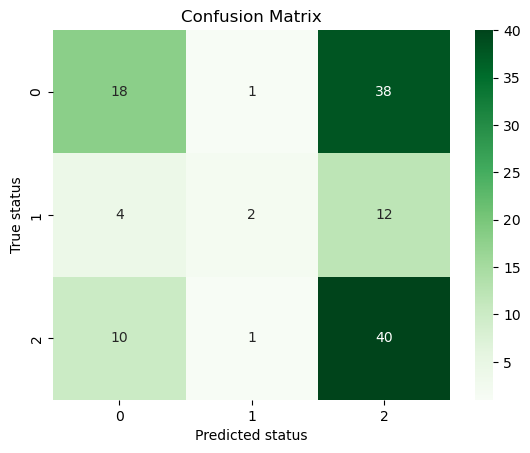

In [139]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced',
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)
cm_default = confusion_matrix(y_test, y_pred)
conf_matrix_heatmap(cm_default)

              precision    recall  f1-score   support

    Improved       0.28      0.55      0.37        29
   No change       0.11      0.40      0.17         5
    Worsened       0.78      0.43      0.56        92

    accuracy                           0.46       126
   macro avg       0.39      0.46      0.37       126
weighted avg       0.64      0.46      0.50       126



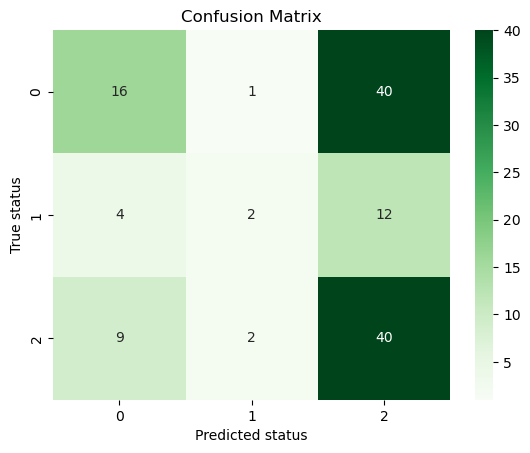

In [140]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import make_pipeline

# Average CV score on the training set was: 0.8107226107226108
Pipeline_RFE_RF = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.8, n_estimators=100), step=0.2),
    RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy', 
        oob_score=True, 
        class_weight='balanced',
        random_state=CID)
)


Pipeline_RFE_RF.fit(X_train, y_train)

y_val_RFE_RF = Pipeline_RFE_RF.predict(X_test) 
   
# classification report 
print(classification_report(y_val_RFE_RF, y_test)) 
cm_default = confusion_matrix(y_test, y_val_RFE_RF)
conf_matrix_heatmap(cm_default)

# Classify progression based on difference in feature vector for non-robustly split KNN pairs

In [118]:
vgg19_feature_severity = pd.read_csv('vgg19_feature_severity.csv',index_col=0)
merged_df = pd.read_csv('paired_image_severity.csv',index_col=0)
vgg19_feature_list = np.array(vgg19_feature_severity.iloc[:, 2:12803])
print(vgg19_feature_list.shape)

ImageA_feature = vgg19_feature_list[merged_df['ImageA']]
ImageB_feature = vgg19_feature_list[merged_df['ImageB']]
Feature_difference = ImageB_feature - ImageA_feature
Feature_concat = np.concatenate([ImageA_feature, ImageB_feature], axis =1)

(467, 12800)


training data: Feature_difference

training label: merged_df['Progression']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(Feature_difference, merged_df['Progression'], test_size=0.20, random_state=CID)
y_train_cat = y_train
y_test_cat = y_test

In [120]:
joblib.dump((Feature_difference, merged_df['Progression']),'dermnet_X_y.pkl')

['dermnet_X_y.pkl']

              precision    recall  f1-score   support

    Improved       0.59      0.85      0.70        41
   No change       1.00      0.15      0.27        13
    Worsened       0.62      0.48      0.55        31

    accuracy                           0.61        85
   macro avg       0.74      0.50      0.50        85
weighted avg       0.67      0.61      0.58        85

accuracy: 0.611764705882353


Progression
Improved     41
Worsened     31
No change    13
Name: count, dtype: int64

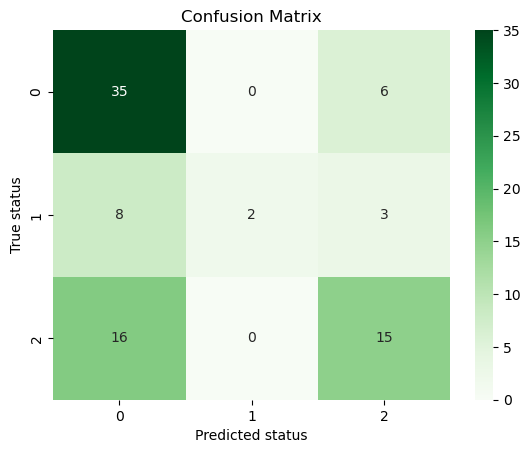

In [116]:
# define the classifier with default parameters
rf_default = RandomForestClassifier(random_state=CID)
y_pred_default = rf_default.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred_default))
print('accuracy:', accuracy_score(y_test, y_pred_default))

cm_default = confusion_matrix(y_test, y_pred_default)
conf_matrix_heatmap(cm_default)
display(y_test.value_counts()) # to see the class breakdown in the test-set 


In [150]:
rf = RandomForestClassifier(
    oob_score=True
)

# define parameters range or set more than one sklearn-given options
param_grid = {'n_estimators': np.arange(300,501, 200), 
              'criterion': ['gini'], 
              'class_weight': ['balanced'],
              'max_features': [ None]
             }

gridcv = GridSearchCV(rf, param_grid, refit=True, cv=5, verbose=1, n_jobs=-1)


# fit the model for grid search 
gridcv.fit(X_train, y_train) 
 
# display best parameters after tuning 
display(gridcv.best_params_) 
gridcv_pred = gridcv.predict(X_test) 
print('cv_accuracy:', gridcv.best_score_)
   
# classification report 
print(classification_report(y_test, gridcv_pred)) 

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': None,
 'n_estimators': 500}

              precision    recall  f1-score   support

    Improved       0.65      0.71      0.68        49
   No change       0.50      0.23      0.32        13
    Worsened       0.40      0.43      0.42        23

    accuracy                           0.56        85
   macro avg       0.52      0.46      0.47        85
weighted avg       0.56      0.56      0.55        85



In [122]:
rf = RandomForestClassifier(
    n_estimators=1000, 
    criterion='entropy', 
    oob_score=True, 
    class_weight='balanced',
    random_state=CID
)
y_pred = rf.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_pred))
print('accuracy:', accuracy_score(y_test, y_pred)) # if you want to look at extra decimals
print('oob score:', rf.oob_score_)
joblib.dump(rf, 'rf_1000trees.pkl')

              precision    recall  f1-score   support

    Improved       0.55      0.80      0.65        41
   No change       0.50      0.15      0.24        13
    Worsened       0.57      0.39      0.46        31

    accuracy                           0.55        85
   macro avg       0.54      0.45      0.45        85
weighted avg       0.55      0.55      0.52        85

accuracy: 0.5529411764705883
oob score: 0.5476190476190477


['rf_1000trees.pkl']

In [121]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

# Average CV score on the training set was: 0.8107226107226108
Pipeline_RFE_RF = make_pipeline(
    RFE(estimator=ExtraTreesClassifier(criterion="gini", max_features=0.8, n_estimators=100), step=0.2),
    RandomForestClassifier(
        n_estimators=1000, 
        criterion='entropy', 
        oob_score=True, 
        class_weight='balanced',
        random_state=CID)
)


Pipeline_RFE_RF.fit(X_train, y_train)

y_val_RFE_RF = Pipeline_RFE_RF.predict(X_test) 
   
# classification report 
print(classification_report(y_val_RFE_RF, y_test)) 

joblib.dump(Pipeline_RFE_RF, 'Pipeline_RFE_RF.pkl')

              precision    recall  f1-score   support

    Improved       0.83      0.57      0.67        60
   No change       0.15      0.50      0.24         4
    Worsened       0.39      0.57      0.46        21

    accuracy                           0.56        85
   macro avg       0.46      0.55      0.46        85
weighted avg       0.69      0.56      0.60        85



['Pipeline_RFE_RF.pkl']

# Regress on difference in severity based on difference in feature vector

In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.preprocessing import StandardScaler, scale, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet # for Lasso and Elastic Net logistic regression
from sklearn.svm import SVC, LinearSVC, NuSVC, SVR, NuSVR, LinearSVR
from sklearn.cross_decomposition import PLSRegression # for PLS

In [28]:
merged_df

,Unnamed: 0,ImageA,ImageB,SeverityA,SeverityB,SeverityB - SeverityA,Progression
0,0,0,510,10,11,1,Worsend
1,1,1,169,10,9,-1,Improved
2,2,1,16,10,12,2,Worsend
3,3,1,284,10,8,-2,Improved
4,4,1,108,10,7,-3,Improved
...,...,...,...,...,...,...,...
419,419,475,479,10,8,-2,Improved
420,420,476,479,6,8,2,Worsend
421,421,478,479,11,8,-3,Improved
422,422,479,507,8,7,-1,Improved


In [124]:
X_train, X_test, y_train, y_test = train_test_split(Feature_difference, merged_df['SeverityB - SeverityA'], test_size=0.20, random_state=CID)

# Normalize Data
scaler = StandardScaler()
# Fit and Transform X_train
X_train_scaled = scaler.fit_transform(X_train)
# Transform X_test
X_test_scaled = scaler.transform(X_test)

In [51]:
# This is just a helper function to get the smape metric - no need to change 
def smape(A, F):
    out =  100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))
    return(out)

## Here we will define several helper functions to compute these metrics 
def RegmodelPerformance(y_true, y_pred):
    exp_var = metrics.explained_variance_score(y_true, y_pred)
    r_square = metrics.r2_score(y_true, y_pred)
    MSE = metrics.mean_squared_error(y_true, y_pred)
    MAE = metrics.mean_absolute_error(y_true, y_pred)
    SMAPE = smape(np.array(y_true), y_pred)
    return(exp_var, r_square, MSE, MAE, SMAPE)

def regression_plot(y_true, y_pred):
        # Calculate R^2 value
    r2 = metrics.r2_score(y_true, y_pred) 

    # Plotting
    plt.scatter(y_true, y_pred)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='perfect model')
    plt.title(f'Actual vs. Predicted with R^2 = {r2:.2f}')
    plt.xlabel('Actual Severity')
    plt.ylabel('Predicted Severity')
    plt.legend()
    plt.show()

def printPerformance(y_true, y_pred):
    exp_var, r_square, MSE, MAE, SMAPE = RegmodelPerformance(y_true, y_pred)
    print("explained variance score = " "%.4f" % exp_var)
    print("R2 = " "%.4f" % r_square)
    print("MSE = " "%.4f" % MSE)
    print("MAE = " "%.4f" % MAE)
    print("SMAPE = " "%.4f" % SMAPE)
    np.set_printoptions(precision=2)
    regression_plot(y_true, y_pred)
    metric = np.array([exp_var, r_square, MSE, MAE, SMAPE])
    return(metric)

In [66]:
# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits=20, n_repeats=3, random_state=CID)
# define grid
grid = dict()
grid['alpha'] = np.arange(0.03, 0.09, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# standard scaled 
# perform the search
results = search.fit(X_train_scaled, y_train)
# summarize
print('MAE: %.3f' % (results.best_score_*-1))
print('Config: %s' % results.best_params_)


MAE: 1.955
Config: {'alpha': 0.08000000000000002}


Lasso metrics: 
explained variance score = 0.2458
R2 = 0.1973
MSE = 8.4160
MAE = 2.2163
SMAPE = 132.7322


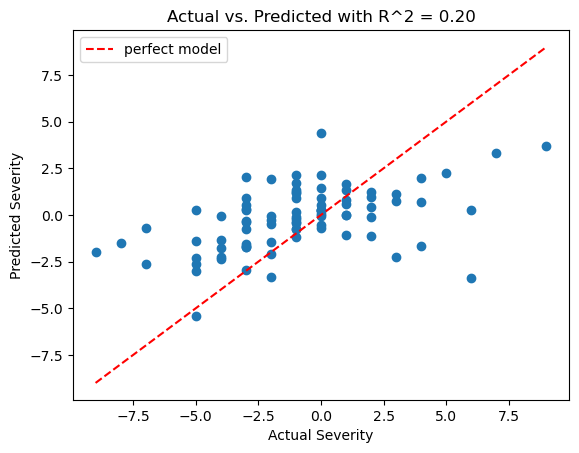

array([  0.25,   0.2 ,   8.42,   2.22, 132.73])

In [67]:
print("Lasso metrics: ")
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

              precision    recall  f1-score   support

    Improved       0.78      0.51      0.62        49
   No change       0.24      0.46      0.32        13
    Worsened       0.46      0.57      0.51        23

    accuracy                           0.52        85
   macro avg       0.50      0.51      0.48        85
weighted avg       0.61      0.52      0.54        85

accuracy: 0.5176470588235295


Progression
Improved     49
Worsened     23
No change    13
Name: count, dtype: int64

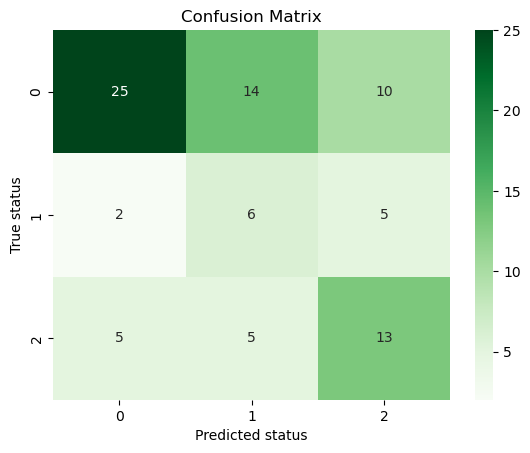

In [87]:
# Convert Lasso result to 3 classes
# Function to categorize values
def categorize_value(value):
    if value > 0.5:
        return 'Worsened'
    elif value < -0.5:
        return 'Improved'
    else:
        return 'No change'

# Apply the function to create a new categorical column
y_pred_lasso_cat = np.vectorize(categorize_value)(y_pred)

print(classification_report(y_test_cat, y_pred_lasso_cat))
print('accuracy:', accuracy_score(y_test_cat, y_pred_lasso_cat))

cm_default = confusion_matrix(y_test_cat, y_pred_lasso_cat)
conf_matrix_heatmap(cm_default)
display(y_test_cat.value_counts()) # to see the class breakdown in the test-set 

/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.833e-01, tolerance: 2.623e-01
  model = cd_fast.enet_coordinate_descent(
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.134e-01, tolerance: 2.517e-01
  model = cd_fast.enet_coordinate_descent(
/Users/kexinxu/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

Config: {'alpha': 0.5, 'l1_ratio': 0.1}
explained variance score = 0.2122
R2 = 0.1655
MSE = 8.7501
MAE = 2.2791
SMAPE = 141.2254


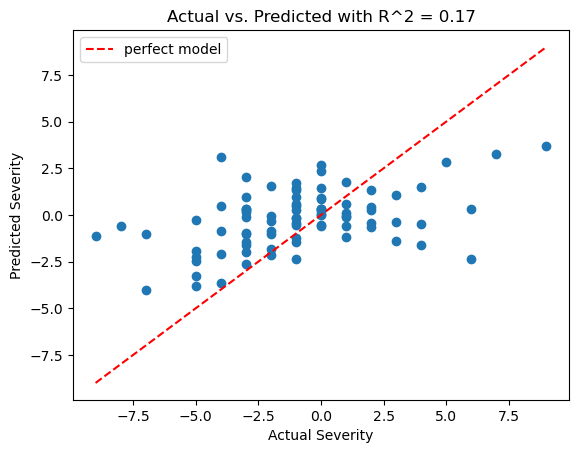

array([  0.21,   0.17,   8.75,   2.28, 141.23])

In [93]:
# define model
model = ElasticNet()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=CID)
# define grid
grid = dict()
grid = {
                      "alpha": [0.1,  0.3, 0.5],
                      "l1_ratio": np.arange(0.1, 0.71, 0.1)}
# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train_scaled, y_train)
print('Config: %s' % results.best_params_)

# test set performane 
y_pred = search.predict(X_test_scaled)
printPerformance(y_test, y_pred)

              precision    recall  f1-score   support

    Improved       0.76      0.53      0.63        49
   No change       0.21      0.46      0.29        13
    Worsened       0.36      0.35      0.36        23

    accuracy                           0.47        85
   macro avg       0.45      0.45      0.42        85
weighted avg       0.57      0.47      0.50        85

accuracy: 0.47058823529411764


Progression
Improved     49
Worsened     23
No change    13
Name: count, dtype: int64

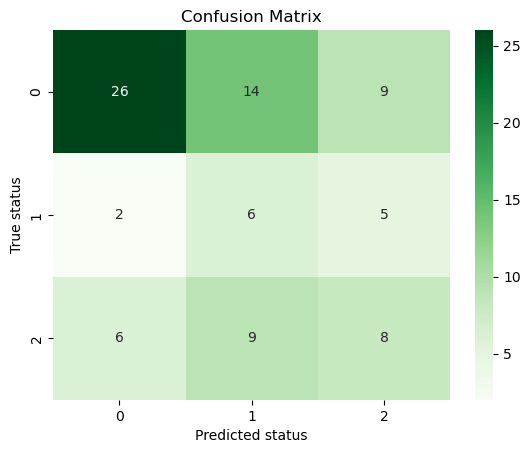

In [94]:
# Convert Enet result to 3 classes
# Function to categorize values
def categorize_value(value):
    if value > 0.5:
        return 'Worsened'
    elif value < -0.5:
        return 'Improved'
    else:
        return 'No change'

# Apply the function to create a new categorical column
y_pred_enet_cat = np.vectorize(categorize_value)(y_pred)

print(classification_report(y_test_cat, y_pred_enet_cat))
print('accuracy:', accuracy_score(y_test_cat, y_pred_enet_cat))

cm_default = confusion_matrix(y_test_cat, y_pred_enet_cat)
conf_matrix_heatmap(cm_default)
display(y_test_cat.value_counts()) # to see the class breakdown in the test-set 